In [1]:
from functions import *
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
!pwd

/home/pekudrjavtseva/transformers/notebooks


In [3]:
PRETRAINED_PATH = '/home/pekudrjavtseva/transformers/checkpoints/cycle/CycleMLP_B5.pth'

LABELS_PATH = '/home/pekudrjavtseva/transformers/data/dogs/labels.csv'

MODEL_SAVE_PATH = '/home/pekudrjavtseva/transformers/models/CycleMLP.pth'

MODEL_SAVE_PATH_SHORT = '/home/pekudrjavtseva/transformers/models/CycleMLP_short.pth'

TRAIN_DIR = Path('/home/pekudrjavtseva/transformers/data/dogs/train')

TEST_DIR = Path('/home/pekudrjavtseva/transformers/data/dogs/test')

TRAIN_DIR_SHORT = Path('/home/pekudrjavtseva/transformers/data/dogs_short')

RESULT_PATH_FULL = '/home/pekudrjavtseva/transformers/predictions/CycleMLP_full.csv'

RESULT_PATH_SHORT = '/home/pekudrjavtseva/transformers/predictions/CycleMLP_short.csv'

DEVICE = torch.device("cuda")

In [4]:
%cd ../image-classification

/home/pekudrjavtseva/transformers/image-classification


In [6]:
from models import get_model

model = get_model('CycleMLP', 'B5', pretrained=PRETRAINED_PATH)

In [7]:
d = create_labels(LABELS_PATH)

In [8]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

train_val_labels = [d[path.name] for path in train_val_files]

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

train_dataset = DogsDataset(train_files, mode='train', label_path = LABELS_PATH)

val_dataset = DogsDataset(val_files, mode='val', label_path = LABELS_PATH)

test_dataset = DogsDataset(test_files, mode='test', label_path = LABELS_PATH)

In [9]:
torch.cuda.set_device(2)
torch.cuda.empty_cache()
name = MODEL_SAVE_PATH

opt = torch.optim.AdamW(model.parameters(), lr=3e-5, amsgrad=True)
history = train(train_dataset, val_dataset, model= model.cuda(), opt = opt, epochs=10, batch_size=16, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.4808755387733585


epoch:  10%|█         | 1/10 [02:56<26:30, 176.71s/it]

Saved model with val acc 0.8063380281690141

Epoch 001 train_loss: 2.4809   val_loss 0.6805 train_acc 0.5012 val_acc 0.8063
loss 0.3377683569384754


epoch:  20%|██        | 2/10 [05:57<23:42, 177.83s/it]

Saved model with val acc 0.8560250391236307

Epoch 002 train_loss: 0.3378   val_loss 0.4882 train_acc 0.9035 val_acc 0.8560
loss 0.1014428341784557


epoch:  30%|███       | 3/10 [08:57<20:49, 178.49s/it]


Epoch 003 train_loss: 0.1014   val_loss 0.5021 train_acc 0.9725 val_acc 0.8521
loss 0.03136487918004598


epoch:  40%|████      | 4/10 [11:58<17:55, 179.19s/it]

Saved model with val acc 0.8775430359937403

Epoch 004 train_loss: 0.0314   val_loss 0.4199 train_acc 0.9937 val_acc 0.8775
loss 0.008536329835293338


epoch:  50%|█████     | 5/10 [14:58<14:57, 179.55s/it]

Saved model with val acc 0.8794992175273866

Epoch 005 train_loss: 0.0085   val_loss 0.4282 train_acc 0.9991 val_acc 0.8795
loss 0.005230891170445951


epoch:  60%|██████    | 6/10 [17:58<11:58, 179.57s/it]


Epoch 006 train_loss: 0.0052   val_loss 0.4322 train_acc 0.9993 val_acc 0.8795
loss 0.0037599780638462883


epoch:  70%|███████   | 7/10 [20:58<08:59, 179.79s/it]

Saved model with val acc 0.8798904538341158

Epoch 007 train_loss: 0.0038   val_loss 0.4412 train_acc 0.9995 val_acc 0.8799
loss 0.0032222916986178554


epoch:  80%|████████  | 8/10 [23:56<05:58, 179.39s/it]

Saved model with val acc 0.88302034428795

Epoch 008 train_loss: 0.0032   val_loss 0.4437 train_acc 0.9995 val_acc 0.8830
loss 0.002509631884228494


epoch:  90%|█████████ | 9/10 [26:54<02:58, 178.87s/it]


Epoch 009 train_loss: 0.0025   val_loss 0.4572 train_acc 0.9996 val_acc 0.8803
loss 0.0024185554408270283


epoch: 100%|██████████| 10/10 [29:52<00:00, 179.21s/it]


Epoch 010 train_loss: 0.0024   val_loss 0.4580 train_acc 0.9995 val_acc 0.8803


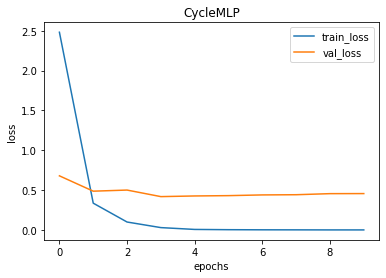

In [10]:
plot(history, "CycleMLP")

In [11]:
def make_prediction(name, model, test_files):
    checkpoint = torch.load(name)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    test_dataset = DogsDataset(test_files, mode='test', label_path = LABELS_PATH)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=2)

    probs = predict(model, test_loader)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    result = pd.DataFrame(columns = label_encoder.inverse_transform(np.arange(0, 120)))

    result['id'] = [path.name.split('.')[0] for path in test_files]

    for i in range(len(test_files)):
        result.iloc[i, :-1] = probs[i][:120]

    return result

In [12]:
res = make_prediction(name, model, test_files)
res.to_csv(RESULT_PATH_FULL, index = False)

Kaggle score 0.46992

In [13]:
train_val_files_short = sorted(list(TRAIN_DIR_SHORT.rglob('*.jpg')))

train_val_labels_short = [d[path.name] for path in train_val_files_short]

train_files_short, val_files_short = train_test_split(train_val_files_short, test_size=0.25, \
 stratify=train_val_labels_short)

train_dataset_short = DogsDataset(train_files_short, mode='train',  label_path = LABELS_PATH)

val_dataset_short = DogsDataset(val_files_short, mode='val',  label_path = LABELS_PATH)

In [14]:
torch.cuda.empty_cache()

model = get_model('CycleMLP', 'B5', pretrained=PRETRAINED_PATH)
name = MODEL_SAVE_PATH_SHORT


opt = torch.optim.AdamW(model.parameters(), lr=3e-5, amsgrad=True)
history = train(train_dataset_short, val_dataset_short, model= model.cuda(), opt = opt, epochs=10, batch_size=16, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.8370329644505246


epoch:  10%|█         | 1/10 [01:05<09:51, 65.68s/it]

Saved model with val acc 0.5025906735751295

Epoch 001 train_loss: 4.8370   val_loss 2.1785 train_acc 0.1072 val_acc 0.5026
loss 0.9640788236841621


epoch:  20%|██        | 2/10 [02:13<08:49, 66.20s/it]

Saved model with val acc 0.7699481865284974

Epoch 002 train_loss: 0.9641   val_loss 0.8009 train_acc 0.7569 val_acc 0.7699
loss 0.2047088899511849


epoch:  30%|███       | 3/10 [03:21<07:47, 66.77s/it]

Saved model with val acc 0.7979274611398963

Epoch 003 train_loss: 0.2047   val_loss 0.6909 train_acc 0.9474 val_acc 0.7979
loss 0.05300067940966469


epoch:  40%|████      | 4/10 [04:29<06:43, 67.23s/it]

Saved model with val acc 0.8020725388601035

Epoch 004 train_loss: 0.0530   val_loss 0.6471 train_acc 0.9910 val_acc 0.8021
loss 0.016004824671471803


epoch:  50%|█████     | 5/10 [05:38<05:38, 67.73s/it]

Saved model with val acc 0.8165803108808289

Epoch 005 train_loss: 0.0160   val_loss 0.6122 train_acc 0.9993 val_acc 0.8166
loss 0.006038124879170338


epoch:  60%|██████    | 6/10 [06:46<04:30, 67.71s/it]


Epoch 006 train_loss: 0.0060   val_loss 0.6185 train_acc 1.0000 val_acc 0.8166
loss 0.0037822770753445137


epoch:  70%|███████   | 7/10 [07:54<03:23, 67.87s/it]

Saved model with val acc 0.8176165803108808

Epoch 007 train_loss: 0.0038   val_loss 0.6258 train_acc 1.0000 val_acc 0.8176
loss 0.0029237413357680515


epoch:  80%|████████  | 8/10 [09:02<02:16, 68.07s/it]

Saved model with val acc 0.8186528497409326

Epoch 008 train_loss: 0.0029   val_loss 0.6297 train_acc 1.0000 val_acc 0.8187
loss 0.002380023531700751


epoch:  90%|█████████ | 9/10 [10:11<01:08, 68.27s/it]

Saved model with val acc 0.8207253886010363

Epoch 009 train_loss: 0.0024   val_loss 0.6343 train_acc 1.0000 val_acc 0.8207
loss 0.002003163400712844


epoch: 100%|██████████| 10/10 [11:19<00:00, 67.94s/it]


Epoch 010 train_loss: 0.0020   val_loss 0.6384 train_acc 1.0000 val_acc 0.8187


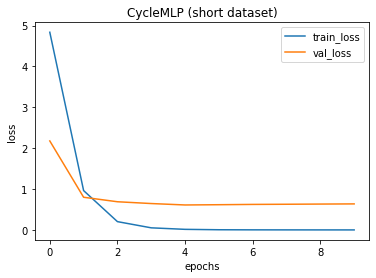

In [15]:
plot(history, "CycleMLP (short dataset)")

In [16]:
res = make_prediction(name, model, test_files)
res.to_csv(RESULT_PATH_SHORT, index = False)

Kaggle score 0.61695